In [1]:
# https://www.quantinsti.com/blog/deep-learning-artificial-neural-network-tensorflow-python

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import talib # technical analysis library
import random

In [3]:
dataset = pd.read_csv("./dataset/AAPL.csv")
dataset = dataset.dropna()
dataset = dataset[['Open','High','Low','Close']]

In [4]:
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window=3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window=10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window=30).mean()
dataset['Std_dev'] = dataset['Close'].rolling(5).std()
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod=9)
dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)

In [5]:
dataset['Price_Rise'] = np.where(dataset['Close'].shift(-1)>dataset['Close'], 1, 0)

In [6]:
dataset = dataset.dropna()

In [7]:
# remove OHLC
data = dataset.iloc[:, 4:]

In [8]:
# conver numpy
n = data.shape[0]
p = data.shape[1]
data = data.values

In [9]:
# training and testing
train_start = 0
train_end = int(np.floor(0.8*n))
test_start = train_end+1
test_end = n
data_train = data[np.arange(train_start, train_end), :]
data_test = data[np.arange(test_start, test_end),:]

In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [11]:
X_train = data_train[:, 0:-1]
y_train = data_train[:, -1]
X_test = data_test[:, 0:-1]
y_test = data_test[:, -1]

In [12]:
# Artificial Neural Network
n_features =X_train.shape[1] 
n_neurons_1 = 512
n_neurons_2 = 256
n_neurons_3 = 128
net = tf.InteractiveSession()

In [13]:
X = tf.placeholder(dtype=tf.float32, shape=[None, n_features])
Y = tf.placeholder(dtype=tf.float32, shape=[None])

In [14]:
sigma = 1
weight_initializer = tf.variance_scaling_initializer(mode='fan_avg', distribution="uniform", scale=sigma)
bias_initializer = tf.zeros_initializer()

In [15]:
# neural network design
W_hidden_1 = tf.Variable(weight_initializer([n_features, n_neurons_1]))
bias_hidden_1 = tf.Variable(bias_initializer([n_neurons_1]))
W_hidden_2 = tf.Variable(weight_initializer([n_neurons_1, n_neurons_2]))
bias_hidden_2 = tf.Variable(bias_initializer([n_neurons_2]))
W_hidden_3 = tf.Variable(weight_initializer([n_neurons_2, n_neurons_3]))
bias_hidden_3 = tf.Variable(bias_initializer([n_neurons_3]))

W_out = tf.Variable(weight_initializer([n_neurons_3, 1]))
bias_out = tf.Variable(bias_initializer([1]))

In [16]:
# neural network composition
hidden_1 = tf.nn.relu(tf.add(tf.matmul(X, W_hidden_1), bias_hidden_1))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, W_hidden_2), bias_hidden_2))
hidden_3 = tf.nn.relu(tf.add(tf.matmul(hidden_2, W_hidden_3), bias_hidden_3))
out = tf.transpose(tf.add(tf.matmul(hidden_3, W_out), bias_out))

In [17]:
mse = tf.reduce_mean(tf.squared_difference(out, Y))

In [18]:
opt = tf.train.AdamOptimizer().minimize(mse)

In [19]:
init = tf.global_variables_initializer()
net.run(init)

In [20]:
# training nn
batch_size = 100
epochs = 10 
for e in range(epochs):
    shuffle_data = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_data]
    y_train = y_train[shuffle_data]
    # minibatch training
    for i in range(0, len(y_train)//batch_size):
        start = i*batch_size
        batch_x = X_train[start:start+batch_size]
        batch_y = y_train[start:start+batch_size]
        net.run(opt, feed_dict={X: batch_x, Y: batch_y})

In [21]:
pred = net.run(out, feed_dict={X: X_test})
y_pred = pred[0]
y_pred = pred[0]>0.5

In [22]:
dataset['y_pred'] = np.NaN
dataset.iloc[(len(dataset)-len(y_pred)):, -1:] = y_pred
trade_dataset = dataset.dropna()

In [23]:
trade_dataset

,Open,High,Low,Close,H-L,O-C,3day MA,10day MA,30day MA,Std_dev,RSI,Williams %R,Price_Rise,y_pred
7676,47.428570,48.020000,47.247143,48.020000,0.772857,0.591430,48.589047,49.369000,48.885047,0.882598,35.559063,-71.925276,1,False
7677,48.067142,48.721428,48.000000,48.552856,0.721428,0.485714,48.092381,49.196714,48.861000,0.716427,43.901511,-52.568804,1,False
7678,48.868572,48.915714,48.381428,48.647144,0.534286,-0.221428,48.062380,49.058142,48.865666,0.461112,45.310902,-49.143708,0,False
7679,48.508572,48.707142,47.860001,47.888573,0.847141,-0.619999,48.406667,48.969286,48.877523,0.442022,36.916446,-72.605168,0,False
7680,47.138573,47.997143,47.060001,47.771427,0.937142,0.632854,48.362858,48.805857,48.863904,0.398317,35.765287,-70.410093,0,False
7681,47.928570,47.985714,47.334286,47.455715,0.651428,-0.472855,48.102381,48.617285,48.860762,0.516095,32.675986,-78.675905,1,False
7682,47.632858,48.365715,47.549999,48.111427,0.815716,0.478569,47.705238,48.370714,48.867381,0.444117,43.981809,-43.341131,0,False
7683,47.995716,48.127144,47.775715,47.857143,0.351429,-0.138573,47.779523,48.221428,48.888238,0.237710,40.979488,-57.043896,1,False
7684,47.828571,48.232857,47.758572,48.201427,0.474285,0.372856,47.808095,48.056143,48.882857,0.295466,46.538244,-38.491243,1,False
7685,48.728573,49.689999,48.714287,49.689999,0.975712,0.961426,48.056666,48.012000,48.906619,0.848458,63.335171,-0.000000,0,False


In [24]:
# computing strategy return
trade_dataset['Tomorrows Returns'] = 0.
trade_dataset['Tomorrows Returns'] = np.log(trade_dataset['Close']/trade_dataset['Close'].shift(1))
trade_dataset['Tomorrows Returns'] = trade_dataset['Tomorrows Returns'].shift(-1)

/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set

In [25]:
trade_dataset['Strategy Returns'] = 0.
trade_dataset['Strategy Returns'] = np.where(trade_dataset['y_pred']==True, trade_dataset['Tomorrows Returns'], -trade_dataset['Tomorrows Returns'])

/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [26]:
trade_dataset['Cumulative Market Returns'] = np.cumsum(trade_dataset['Tomorrows Returns'])
trade_dataset['Cumulative Strategy Returns'] = np.cumsum(trade_dataset['Strategy Returns'])

/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sharavsambuu/src/stock-price-prediction-exp/env/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


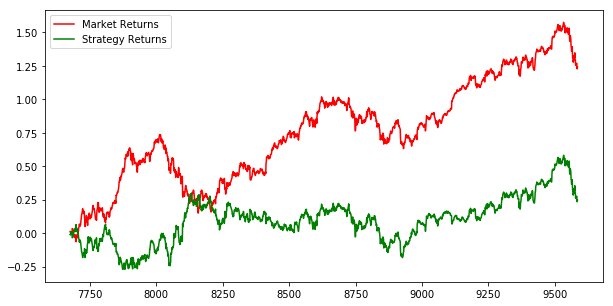

In [27]:
plt.figure(figsize=(10,5))
plt.plot(trade_dataset['Cumulative Market Returns'], color='r', label='Market Returns')
plt.plot(trade_dataset['Cumulative Strategy Returns'], color='g', label='Strategy Returns')
plt.legend()
plt.show()